In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
import os
from tensorflow.keras.datasets import fashion_mnist,mnist,cifar10
from tensorflow.keras.layers import Conv2D,Activation,BatchNormalization,UpSampling2D,Embedding,ZeroPadding2D, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout,MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Progbar
from keras.initializers import RandomNormal
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils as np_utils

In [2]:
nb_classes = 10
batch_size = 128
maxepoches = 250
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [3]:
#Loading and splitting the dataset into train, validation and test
(X_Train, y_Train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_Train, y_Train, test_size=0.20)
# convert y_train and y_test to categorical binary values 
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [4]:
X_Train.shape

(50000, 32, 32, 3)

In [5]:
# Reshape them to batch_size, width,height,#channels
X_train = X_train.reshape(40000, 32, 32, 3)
X_val = X_val.reshape(10000, 32, 32, 3)
X_test = X_test.reshape(10000, 32, 32, 3)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# Normalize the values
X_train /= 255
X_val /= 255
X_test /= 255

In [6]:
# settings
init=RandomNormal(mean=0,stddev=0.02)
input_shape = (32, 32, 3) # Input shape of each image
weight_decay = 0.0005

# Network Creation
def build_model():
    # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same',
                     input_shape=input_shape,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256,kernel_regularizer=regularizers.l2(weight_decay), name='dense_1'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(10, name='dense_2'))
    model.add(Activation('softmax'))
    return model

teacher = build_model()
sgd = SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
teacher.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])


In [7]:
#  You can download the weights here, filename = Cifar10_Teacher
url = "https://drive.google.com/file/d/175vv6228njC1EfpH9jeAAoroG1U9BB46/view?usp=sharing"

In [8]:
# teacher.fit(X_train,Y_train,batch_size=128,epochs=150,verbose=1,callbacks=[reduce_lr],validation_data=(X_val,Y_val))

In [9]:
teacher.load_weights("Cifar10_Teacher.h5")

In [10]:
# Y_test = np_utils.to_categorical(y_test, nb_classes)
loss, acc =teacher.evaluate(X_test, y_test, verbose=1)
loss, acc

313/313 [==============================] - 5s 8ms/step - loss: 0.8247 - accuracy: 0.8996


(0.834343671798706, 0.8992000222206116)

In [11]:
#Collect the dense vector from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(teacher.input, teacher.get_layer('dense_1').output)

In [12]:
#Extracting dense representation from the teacher network
train_dense = teacher_WO_Softmax.predict(X_train)

In [13]:
#Splitting the training dense vector among N students
s1Train=train_dense[:,:64]
s2Train=train_dense[:,64:128]
s3Train=train_dense[:,128:192]
s4Train=train_dense[:,192:256]

In [15]:
def define_model(name):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3), name=name))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform',name='req'+name))

    # compile model
    # opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

student1 = define_model('s1')
student1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
s1 (Conv2D)                  (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)         

In [16]:
# import np.random import random
BATCH_SIZE=32
def smooth_real_labels(y):
    return y - 0.3+(np.random.random(y.shape)*0.5)
def smooth_fake_labels(y):
    return y + (0.3 * np.random.random(y.shape))
def build_gan(gen,disc): 
    disc.trainable = False
    input= Input(shape=input_shape)
    output = gen(input)
    output2= disc(output)
    gan=Model(input,output2)

    gan.compile(Adam(lr=0.0002),loss=['binary_crossentropy','mse'],metrics=['accuracy'])

    return gan

In [17]:
def build_sdiscriminator():
    
    input2 = Input(shape=(64,),name='input')
    inp=Dense(128)(input2)

    leaky_relu = LeakyReLU(alpha=0.2)(inp)
    
    conv3 = Dense(128,activation='relu')(leaky_relu)
    b_n = BatchNormalization()(conv3)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv3 = Dense(128,activation='relu')(leaky_relu)
    b_n = BatchNormalization()(conv3)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv3 = Dense(128,activation='relu')(b_n)
    b_n = BatchNormalization()(conv3)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv4 = Dense(256,activation='relu')(b_n)
    b_n = BatchNormalization()(conv4)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv4 = Dense(256,activation='relu')(b_n)
    b_n = BatchNormalization()(conv4)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    # conv4 = Dense(512)(leaky_relu)
    # b_n = BatchNormalization()(conv4)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)

    dense = Dense(1,activation='sigmoid')(b_n)

    output2=Dense(64)(b_n)

    
    disc = Model(input2,[dense,output2])          
    disc.compile(optd,loss=['binary_crossentropy','mse'],metrics=['accuracy'])


    return disc

In [18]:
def training(generator,discriminator,gan,features,epo=20):
    # Setup Models here
    BATCH_SIZE = 128
    discriminator.trainable = True
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    all_class_loss=[]
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(epo):
        
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        epoch_class_loss= []
        for i,index in enumerate(indices):
        
            # Write your code here
            inputs=X_train[index:index+BATCH_SIZE]
            real_image = features[index:index+BATCH_SIZE]
            y_train = features[index:index+BATCH_SIZE]

            y_real = np.ones((BATCH_SIZE,1))
            y_fake = np.zeros((BATCH_SIZE,1))

            #Generator Training
            fake_images = generator.predict_on_batch(inputs)

            #Disrciminator Training
            disc_real_loss1,_,disc_real_loss2,_,_= discriminator.train_on_batch(real_image,[y_real,y_train])
            disc_fake_loss1,_,disc_fake_loss2,_,_= discriminator.train_on_batch(fake_images,[y_fake,y_train])

            #Gans Training
            discriminator.trainable = False
            gan_loss,_,gan_loss2,_,_ = gan.train_on_batch(inputs, [y_real,y_train])
            gan_loss,_,gan_loss2,_,_ = gan.train_on_batch(inputs, [y_real,y_train])
            gan_loss,_,gan_loss2,_,_ = gan.train_on_batch(inputs, [y_real,y_train])
            gan_loss,_,gan_loss2,_,_ = gan.train_on_batch(inputs, [y_real,y_train])

            discriminator.trainable = True

            disc_loss = (disc_fake_loss1 + disc_real_loss1)/2
            epoch_disc_loss.append(disc_loss)
            progress_bar.update(i+1)

            epoch_gen_loss.append((gan_loss))

        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)
        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f | " % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))

    return generator

In [19]:
optd = Adam(lr=0.0002)
opt = Adam(lr=0.0001)

discriminator1 = build_sdiscriminator()
s1=define_model("s1")
gan1 = build_gan(s1,discriminator1)
s1 = training(s1,discriminator1,gan1,s1Train,epo=90)


312/312 [==============================] - 30s 91ms/step
Epoch: 1 | Discriminator Loss: 1.723542 | Generator Loss: 2.065445 | 
312/312 [==============================] - 29s 91ms/step
Epoch: 2 | Discriminator Loss: 1.329637 | Generator Loss: 1.875053 | 
312/312 [==============================] - 29s 92ms/step
Epoch: 3 | Discriminator Loss: 1.277050 | Generator Loss: 1.865875 | 
312/312 [==============================] - 29s 94ms/step
Epoch: 4 | Discriminator Loss: 1.203630 | Generator Loss: 1.760023 | 
312/312 [==============================] - 29s 92ms/step
Epoch: 5 | Discriminator Loss: 1.117797 | Generator Loss: 1.618527 | 
312/312 [==============================] - 26s 85ms/step
Epoch: 6 | Discriminator Loss: 1.058487 | Generator Loss: 1.526602 | 
312/312 [==============================] - 29s 94ms/step
Epoch: 7 | Discriminator Loss: 1.016091 | Generator Loss: 1.454672 | 
312/312 [==============================] - 29s 94ms/step
Epoch: 8 | Discriminator Loss: 0.984249 | Generator Lo

312/312 [==============================] - 28s 90ms/step
Epoch: 65 | Discriminator Loss: 0.740387 | Generator Loss: 0.926630 | 
312/312 [==============================] - 28s 89ms/step
Epoch: 66 | Discriminator Loss: 0.740469 | Generator Loss: 0.926517 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 67 | Discriminator Loss: 0.739500 | Generator Loss: 0.925534 | 
312/312 [==============================] - 28s 89ms/step
Epoch: 68 | Discriminator Loss: 0.739472 | Generator Loss: 0.925934 | 
312/312 [==============================] - 28s 88ms/step
Epoch: 69 | Discriminator Loss: 0.738627 | Generator Loss: 0.922582 | 
312/312 [==============================] - 28s 89ms/step
Epoch: 70 | Discriminator Loss: 0.738448 | Generator Loss: 0.920760 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 71 | Discriminator Loss: 0.737674 | Generator Loss: 0.915143 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 72 | Discriminator Loss: 0.737078 | Gene

In [20]:
discriminator2 = build_sdiscriminator()
s2=define_model("s2")
gan2 = build_gan(s2,discriminator2)
s2 = training(s2,discriminator2,gan2,s2Train,epo=90)

312/312 [==============================] - 29s 88ms/step
Epoch: 1 | Discriminator Loss: 1.485832 | Generator Loss: 2.047434 | 
312/312 [==============================] - 29s 91ms/step
Epoch: 2 | Discriminator Loss: 1.325212 | Generator Loss: 1.949951 | 
312/312 [==============================] - 29s 93ms/step
Epoch: 3 | Discriminator Loss: 1.259877 | Generator Loss: 1.860443 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 4 | Discriminator Loss: 1.173141 | Generator Loss: 1.736685 | 
312/312 [==============================] - 29s 93ms/step
Epoch: 5 | Discriminator Loss: 1.100926 | Generator Loss: 1.594568 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 6 | Discriminator Loss: 1.045795 | Generator Loss: 1.510896 | 
312/312 [==============================] - 29s 94ms/step
Epoch: 7 | Discriminator Loss: 1.008466 | Generator Loss: 1.451452 | 
312/312 [==============================] - 28s 91ms/step
Epoch: 8 | Discriminator Loss: 0.977248 | Generator Lo

312/312 [==============================] - 28s 89ms/step
Epoch: 65 | Discriminator Loss: 0.740080 | Generator Loss: 0.908865 | 
312/312 [==============================] - 27s 88ms/step
Epoch: 66 | Discriminator Loss: 0.739715 | Generator Loss: 0.901903 | 
312/312 [==============================] - 28s 91ms/step
Epoch: 67 | Discriminator Loss: 0.739014 | Generator Loss: 0.899230 | 
312/312 [==============================] - 28s 91ms/step
Epoch: 68 | Discriminator Loss: 0.738775 | Generator Loss: 0.900242 | 
312/312 [==============================] - 28s 89ms/step
Epoch: 69 | Discriminator Loss: 0.738234 | Generator Loss: 0.900112 | 
312/312 [==============================] - 28s 91ms/step
Epoch: 70 | Discriminator Loss: 0.737914 | Generator Loss: 0.901246 | 
312/312 [==============================] - 29s 94ms/step
Epoch: 71 | Discriminator Loss: 0.737534 | Generator Loss: 0.899939 | 
312/312 [==============================] - 29s 92ms/step
Epoch: 72 | Discriminator Loss: 0.737163 | Gene

In [21]:
discriminator3 = build_sdiscriminator()
s3=define_model("s3")
gan3 = build_gan(s3,discriminator3)
s3 = training(s3,discriminator3,gan3,s3Train,epo=94)

312/312 [==============================] - 30s 91ms/step
Epoch: 1 | Discriminator Loss: 1.435402 | Generator Loss: 1.954411 | 
312/312 [==============================] - 28s 89ms/step
Epoch: 2 | Discriminator Loss: 1.219973 | Generator Loss: 1.813947 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 3 | Discriminator Loss: 1.122541 | Generator Loss: 1.654982 | 
312/312 [==============================] - 28s 88ms/step
Epoch: 4 | Discriminator Loss: 1.059449 | Generator Loss: 1.534969 | 
312/312 [==============================] - 28s 91ms/step
Epoch: 5 | Discriminator Loss: 1.016224 | Generator Loss: 1.447071 | 
312/312 [==============================] - 28s 91ms/step
Epoch: 6 | Discriminator Loss: 0.980814 | Generator Loss: 1.379157 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 7 | Discriminator Loss: 0.955618 | Generator Loss: 1.344197 | 
312/312 [==============================] - 28s 89ms/step
Epoch: 8 | Discriminator Loss: 0.932322 | Generator Lo

312/312 [==============================] - 28s 90ms/step
Epoch: 65 | Discriminator Loss: 0.734733 | Generator Loss: 0.894536 | 
312/312 [==============================] - 27s 88ms/step
Epoch: 66 | Discriminator Loss: 0.734233 | Generator Loss: 0.889883 | 
312/312 [==============================] - 28s 89ms/step
Epoch: 67 | Discriminator Loss: 0.733937 | Generator Loss: 0.889411 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 68 | Discriminator Loss: 0.733766 | Generator Loss: 0.886357 | 
312/312 [==============================] - 27s 88ms/step
Epoch: 69 | Discriminator Loss: 0.733087 | Generator Loss: 0.884298 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 70 | Discriminator Loss: 0.733076 | Generator Loss: 0.879803 | 
312/312 [==============================] - 28s 89ms/step
Epoch: 71 | Discriminator Loss: 0.732507 | Generator Loss: 0.881069 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 72 | Discriminator Loss: 0.732001 | Gene

In [22]:
discriminator4 = build_sdiscriminator()
s4=define_model("s4")
gan4 = build_gan(s4,discriminator4)
s4 = training(s4,discriminator4,gan4,s4Train,epo=95)

312/312 [==============================] - 29s 89ms/step
Epoch: 1 | Discriminator Loss: 1.397794 | Generator Loss: 1.952409 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 2 | Discriminator Loss: 1.224723 | Generator Loss: 1.770108 | 
312/312 [==============================] - 28s 89ms/step
Epoch: 3 | Discriminator Loss: 1.108148 | Generator Loss: 1.582597 | 
312/312 [==============================] - 29s 92ms/step
Epoch: 4 | Discriminator Loss: 1.038260 | Generator Loss: 1.467807 | 
312/312 [==============================] - 28s 88ms/step
Epoch: 5 | Discriminator Loss: 0.995034 | Generator Loss: 1.379297 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 6 | Discriminator Loss: 0.965544 | Generator Loss: 1.328288 | 
312/312 [==============================] - 28s 91ms/step
Epoch: 7 | Discriminator Loss: 0.940301 | Generator Loss: 1.287927 | 
312/312 [==============================] - 29s 92ms/step
Epoch: 8 | Discriminator Loss: 0.918699 | Generator Lo

312/312 [==============================] - 28s 89ms/step
Epoch: 65 | Discriminator Loss: 0.733813 | Generator Loss: 0.881637 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 66 | Discriminator Loss: 0.733488 | Generator Loss: 0.879665 | 
312/312 [==============================] - 29s 92ms/step
Epoch: 67 | Discriminator Loss: 0.732851 | Generator Loss: 0.878912 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 68 | Discriminator Loss: 0.732689 | Generator Loss: 0.877637 | 
312/312 [==============================] - 28s 89ms/step
Epoch: 69 | Discriminator Loss: 0.732239 | Generator Loss: 0.878063 | 
312/312 [==============================] - 28s 90ms/step
Epoch: 70 | Discriminator Loss: 0.731771 | Generator Loss: 0.878029 | 
312/312 [==============================] - 28s 89ms/step
Epoch: 71 | Discriminator Loss: 0.731372 | Generator Loss: 0.873773 | 
312/312 [==============================] - 28s 91ms/step
Epoch: 72 | Discriminator Loss: 0.731094 | Gene

**4 Students**

In [23]:
o1=s1.get_layer("reqs1").output
o2=s2.get_layer("reqs2").output
o3=s3.get_layer("reqs3").output
o4=s4.get_layer("reqs4").output

output=tensorflow.keras.layers.concatenate([o1,o2,o3,o4])

output=Activation('relu')(output)
output=Dropout(0.5)(output) # For reguralization
output=Dense(10,activation="softmax", name="d1")(output)

compressed=Model([s1.get_layer("s1").input,s2.get_layer("s2").input,
           s3.get_layer("s3").input,s4.get_layer("s4").input], output)
my_weights=teacher.get_layer('dense_2').get_weights()
compressed.get_layer('d1').set_weights(my_weights)

In [29]:
compressed.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s1_input (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
s2_input (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
s3_input (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
s4_input (InputLayer)           [(None, 32, 32, 3)]  0                                            
____________________________________________________________________________________________

In [24]:
i=0
for l in compressed.layers[:len(compressed.layers)-2]:
    l.trainable=False


In [25]:
compressed.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0002),
              metrics=['accuracy'])

In [26]:
# Without finetune
batch_size = 256
mm4_history=compressed.fit([X_train,X_train,X_train,X_train], Y_train,
          batch_size=batch_size,
          epochs=20,
          verbose=1,
          validation_data=([X_val,X_val,X_val,X_val], Y_val))

Epoch 1/20
157/157 [==============================] - 5s 27ms/step - loss: 10.7644 - accuracy: 0.1802 - val_loss: 4.4440 - val_accuracy: 0.3795
Epoch 2/20
157/157 [==============================] - 3s 18ms/step - loss: 5.8315 - accuracy: 0.3345 - val_loss: 1.6645 - val_accuracy: 0.5930
Epoch 3/20
157/157 [==============================] - 3s 18ms/step - loss: 3.2294 - accuracy: 0.5082 - val_loss: 0.8100 - val_accuracy: 0.8181
Epoch 4/20
157/157 [==============================] - 3s 17ms/step - loss: 1.8891 - accuracy: 0.6462 - val_loss: 0.7260 - val_accuracy: 0.8557
Epoch 5/20
157/157 [==============================] - 3s 18ms/step - loss: 1.2628 - accuracy: 0.7381 - val_loss: 0.7245 - val_accuracy: 0.8642
Epoch 6/20
157/157 [==============================] - 3s 18ms/step - loss: 0.9372 - accuracy: 0.7967 - val_loss: 0.7356 - val_accuracy: 0.8675
Epoch 7/20
157/157 [==============================] - 3s 18ms/step - loss: 0.7660 - accuracy: 0.8335 - val_loss: 0.7460 - val_accuracy: 0.869

In [32]:
# Without finetune
batch_size = 256
mm4_history=compressed.fit([X_train,X_train,X_train,X_train], Y_train,
          batch_size=batch_size,
          epochs=20,
          verbose=1,
          validation_data=([X_val,X_val,X_val,X_val], Y_val))

Epoch 1/20
157/157 [==============================] - 3s 21ms/step - loss: 0.1813 - accuracy: 0.9588 - val_loss: 0.4652 - val_accuracy: 0.8760
Epoch 2/20
157/157 [==============================] - 3s 20ms/step - loss: 0.1786 - accuracy: 0.9586 - val_loss: 0.4621 - val_accuracy: 0.8761
Epoch 3/20
157/157 [==============================] - 3s 19ms/step - loss: 0.1729 - accuracy: 0.9598 - val_loss: 0.4613 - val_accuracy: 0.8768
Epoch 4/20
157/157 [==============================] - 3s 18ms/step - loss: 0.1746 - accuracy: 0.9595 - val_loss: 0.4605 - val_accuracy: 0.8765
Epoch 5/20
157/157 [==============================] - 3s 17ms/step - loss: 0.1716 - accuracy: 0.9613 - val_loss: 0.4591 - val_accuracy: 0.8764
Epoch 6/20
157/157 [==============================] - 3s 18ms/step - loss: 0.1732 - accuracy: 0.9599 - val_loss: 0.4565 - val_accuracy: 0.8766
Epoch 7/20
157/157 [==============================] - 3s 19ms/step - loss: 0.1751 - accuracy: 0.9592 - val_loss: 0.4542 - val_accuracy: 0.8767

In [27]:
l,a = compressed.evaluate([X_test,X_test,X_test,X_test], y_test)
l, a

313/313 [==============================] - 5s 15ms/step - loss: 0.7953 - accuracy: 0.8704


(0.7953414916992188, 0.8704000115394592)

In [33]:
l,a = compressed.evaluate([X_test,X_test,X_test,X_test], y_test)
l, a

313/313 [==============================] - 2s 7ms/step - loss: 0.4668 - accuracy: 0.8727


(0.4667777419090271, 0.8726999759674072)

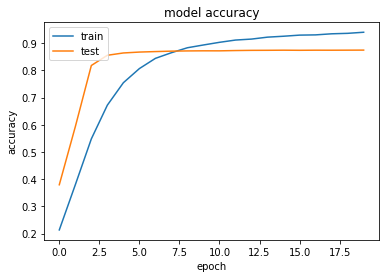

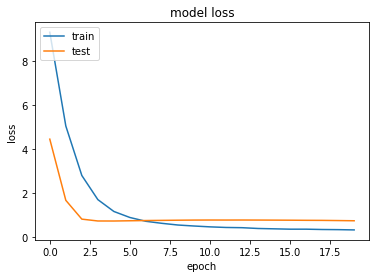

In [28]:
import matplotlib.pyplot as plt
plt.plot(mm4_history.history['accuracy'])
plt.plot(mm4_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(mm4_history.history['loss'])
plt.plot(mm4_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()